# US Stock Algo Trading - V3 HIGH RETURNS
## Aggressive Strategies for Maximum Returns

**Goal:** Achieve 25%+ CAGR with Sharpe > 1.0

**Key Changes from V2:**
1. More concentrated portfolio (15-20 stocks vs 25)
2. Aggressive sector tilts (overweight tech/growth)
3. Shorter momentum lookbacks (capture trends faster)
4. Reduced regime filter impact
5. Focus on high-beta, high-growth stocks
6. Weekly rebalancing option for faster reaction

In [1]:
!pip install -q yfinance pandas numpy matplotlib seaborn tqdm

zsh:1: command not found: pip


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import requests
import warnings
warnings.filterwarnings('ignore')

# Configuration - MORE AGGRESSIVE
TRAIN_START = "2010-01-01"
TRAIN_END = "2020-12-31"
TEST_START = "2021-01-01"
TEST_END = "2024-12-31"
INITIAL_CAPITAL = 100000

# More concentrated for higher returns
TOP_N = 15  # Fewer stocks = more concentrated

print("V3 High Returns Strategy - Setup Complete!")

/Users/austinlev/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


V3 High Returns Strategy - Setup Complete!


## 1. Data Loading

In [3]:
def get_sp500_with_sectors():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    tables = pd.read_html(response.text)
    df = tables[0][['Symbol', 'Security', 'GICS Sector']]
    df = df[~df['GICS Sector'].isin(['Health Care'])]
    return df

tickers_df = get_sp500_with_sectors()
print(f"Stocks: {len(tickers_df)}")
sector_map = dict(zip(tickers_df['Symbol'].str.replace('.', '-'), tickers_df['GICS Sector']))

# Identify growth sectors for overweighting
GROWTH_SECTORS = ['Information Technology', 'Communication Services', 'Consumer Discretionary']
print(f"\nGrowth sectors for overweighting: {GROWTH_SECTORS}")

Stocks: 443

Growth sectors for overweighting: ['Information Technology', 'Communication Services', 'Consumer Discretionary']


In [4]:
def download_data(tickers, start, end):
    clean_tickers = [t.replace('.', '-') for t in tickers]
    data = yf.download(clean_tickers, start=start, end=end, auto_adjust=True, progress=True)
    prices = data['Close'] if 'Close' in data.columns.get_level_values(0) else data
    prices = prices.ffill().bfill()
    missing = prices.isnull().sum() / len(prices)
    prices = prices[missing[missing < 0.1].index]
    return prices

print("Downloading data...")
all_tickers = tickers_df['Symbol'].tolist()
full_prices = download_data(all_tickers, "2009-01-01", TEST_END)
spy = yf.download('SPY', start="2009-01-01", end=TEST_END, auto_adjust=True)['Close']
qqq = yf.download('QQQ', start="2009-01-01", end=TEST_END, auto_adjust=True)['Close']  # Tech benchmark

print(f"\nLoaded {len(full_prices.columns)} stocks")

[                       0%                       ]

[                       0%                       ]  2 of 443 completed

[                       1%                       ]  3 of 443 completed

[                       1%                       ]  4 of 443 completed

[                       1%                       ]  5 of 443 completed

[                       1%                       ]  6 of 443 completed

[*                      2%                       ]  7 of 443 completed

[*                      2%                       ]  8 of 443 completed

[*                      2%                       ]  9 of 443 completed

[*                      2%                       ]  10 of 443 completed

[*                      2%                       ]  11 of 443 completed

[*                      3%                       ]  12 of 443 completed

[*                      3%                       ]  12 of 443 completed

[*                      3%                       ]  14 of 443 completed

[*                      3%                       ]  15 of 443 completed

[**                     4%                       ]  16 of 443 completed

[**                     4%                       ]  17 of 443 completed

[**                     4%                       ]  18 of 443 completed

[**                     4%                       ]  19 of 443 completed

[**                     5%                       ]  20 of 443 completed

[**                     5%                       ]  21 of 443 completed

[**                     5%                       ]  22 of 443 completed

[**                     5%                       ]  23 of 443 completed

[**                     5%                       ]  24 of 443 completed

[***                    6%                       ]  25 of 443 completed

[***                    6%                       ]  26 of 443 completed

[***                    6%                       ]  27 of 443 completed

[***                    6%                       ]  27 of 443 completed

[***                    7%                       ]  29 of 443 completed

[***                    7%                       ]  30 of 443 completed

[***                    7%                       ]  31 of 443 completed

[***                    7%                       ]  32 of 443 completed

[***                    7%                       ]  33 of 443 completed

[****                   8%                       ]  34 of 443 completed

[****                   8%                       ]  35 of 443 completed

[****                   8%                       ]  35 of 443 completed

[****                   8%                       ]  37 of 443 completed

[****                   8%                       ]  37 of 443 completed

[****                   9%                       ]  39 of 443 completed

[****                   9%                       ]  40 of 443 completed

[****                   9%                       ]  41 of 443 completed

[****                   9%                       ]  42 of 443 completed

[*****                 10%                       ]  43 of 443 completed

[*****                 10%                       ]  43 of 443 completed

[*****                 10%                       ]  45 of 443 completed

[*****                 10%                       ]  46 of 443 completed

[*****                 11%                       ]  47 of 443 completed

[*****                 11%                       ]  48 of 443 completed

[*****                 11%                       ]  49 of 443 completed

[******                12%                       ]  51 of 443 completed

[******                12%                       ]  52 of 443 completed

[******                12%                       ]  53 of 443 completed

[******                12%                       ]  54 of 443 completed

[******                12%                       ]  55 of 443 completed

[******                13%                       ]  57 of 443 completed

[******                13%                       ]  58 of 443 completed

[******                13%                       ]  59 of 443 completed

[*******               14%                       ]  60 of 443 completed

[*******               14%                       ]  61 of 443 completed

[*******               14%                       ]  62 of 443 completed

[*******               14%                       ]  63 of 443 completed

[*******               14%                       ]  64 of 443 completed

[*******               15%                       ]  65 of 443 completed

[*******               15%                       ]  66 of 443 completed

[*******               15%                       ]  66 of 443 completed

[********              16%                       ]  69 of 443 completed

[********              16%                       ]  71 of 443 completed

[********              16%                       ]  72 of 443 completed

[********              16%                       ]  73 of 443 completed

[********              17%                       ]  74 of 443 completed

[********              17%                       ]  75 of 443 completed

[********              17%                       ]  75 of 443 completed

[********              17%                       ]  77 of 443 completed

[*********             18%                       ]  79 of 443 completed

[*********             18%                       ]  80 of 443 completed

[*********             18%                       ]  81 of 443 completed

[*********             19%                       ]  83 of 443 completed

[*********             19%                       ]  84 of 443 completed

$SNDK: possibly delisted; no price data found  (1d 2009-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1230786000, endDate = 1735621200")


[*********             19%                       ]  85 of 443 completed

[*********             19%                       ]  86 of 443 completed

[**********            20%                       ]  87 of 443 completed

[**********            20%                       ]  89 of 443 completed

[**********            21%                       ]  93 of 443 completed

[**********            21%                       ]  94 of 443 completed

[**********            21%                       ]  95 of 443 completed

[***********           22%                       ]  96 of 443 completed

[***********           22%                       ]  97 of 443 completed

[***********           22%                       ]  99 of 443 completed

[***********           22%                       ]  99 of 443 completed

[***********           23%                       ]  101 of 443 completed

[***********           23%                       ]  101 of 443 completed

[***********           23%                       ]  103 of 443 completed

[***********           23%                       ]  104 of 443 completed

[************          24%                       ]  105 of 443 completed

[************          24%                       ]  106 of 443 completed

[************          24%                       ]  107 of 443 completed

[************          24%                       ]  108 of 443 completed

[************          25%                       ]  109 of 443 completed

[************          25%                       ]  110 of 443 completed

[************          25%                       ]  111 of 443 completed

[************          26%                       ]  113 of 443 completed

[************          26%                       ]  114 of 443 completed

[************          26%                       ]  115 of 443 completed

[************          26%                       ]  117 of 443 completed

[*************         27%                       ]  118 of 443 completed

[*************         27%                       ]  119 of 443 completed

[*************         27%                       ]  120 of 443 completed

[*************         27%                       ]  121 of 443 completed

[*************         28%                       ]  122 of 443 completed

[*************         28%                       ]  124 of 443 completed

[*************         28%                       ]  126 of 443 completed

[**************        29%                       ]  127 of 443 completed

[**************        29%                       ]  128 of 443 completed

[**************        29%                       ]  129 of 443 completed

[**************        29%                       ]  130 of 443 completed

[**************        30%                       ]  131 of 443 completed

[**************        30%                       ]  132 of 443 completed

[**************        30%                       ]  134 of 443 completed

[***************       31%                       ]  136 of 443 completed

[***************       31%                       ]  137 of 443 completed

[***************       31%                       ]  138 of 443 completed

[***************       31%                       ]  138 of 443 completed

[***************       32%                       ]  141 of 443 completed

[***************       32%                       ]  141 of 443 completed

[***************       32%                       ]  143 of 443 completed

[****************      33%                       ]  145 of 443 completed

[****************      33%                       ]  147 of 443 completed

[****************      33%                       ]  148 of 443 completed

[****************      34%                       ]  150 of 443 completed

[****************      34%                       ]  151 of 443 completed

[****************      34%                       ]  152 of 443 completed

[*****************     35%                       ]  153 of 443 completed

[*****************     35%                       ]  153 of 443 completed

[*****************     35%                       ]  155 of 443 completed

[*****************     35%                       ]  156 of 443 completed

$Q: possibly delisted; no price data found  (1d 2009-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1230786000, endDate = 1735621200")


[*****************     35%                       ]  157 of 443 completed

[*****************     36%                       ]  158 of 443 completed

[*****************     36%                       ]  159 of 443 completed

[*****************     36%                       ]  160 of 443 completed

[*****************     36%                       ]  161 of 443 completed

[******************    37%                       ]  162 of 443 completed

[******************    37%                       ]  163 of 443 completed

[******************    37%                       ]  165 of 443 completed

[******************    37%                       ]  166 of 443 completed

[******************    38%                       ]  167 of 443 completed

[******************    38%                       ]  168 of 443 completed

[******************    38%                       ]  169 of 443 completed

[******************    38%                       ]  170 of 443 completed

[*******************   39%                       ]  171 of 443 completed

[*******************   39%                       ]  172 of 443 completed

[*******************   39%                       ]  173 of 443 completed

[*******************   39%                       ]  174 of 443 completed

[*******************   40%                       ]  175 of 443 completed

[*******************   40%                       ]  175 of 443 completed

[*******************   40%                       ]  177 of 443 completed

[*******************   40%                       ]  178 of 443 completed

[*******************   40%                       ]  179 of 443 completed

[********************  41%                       ]  180 of 443 completed

[********************  41%                       ]  181 of 443 completed

[********************  41%                       ]  182 of 443 completed

[********************  41%                       ]  183 of 443 completed

[********************  42%                       ]  184 of 443 completed

[********************  42%                       ]  185 of 443 completed

[********************  42%                       ]  186 of 443 completed

[********************  42%                       ]  187 of 443 completed

[********************  42%                       ]  188 of 443 completed

[********************* 43%                       ]  189 of 443 completed

[********************* 43%                       ]  190 of 443 completed

[********************* 43%                       ]  191 of 443 completed

[********************* 44%                       ]  193 of 443 completed

[********************* 44%                       ]  194 of 443 completed

[********************* 44%                       ]  195 of 443 completed

[********************* 44%                       ]  196 of 443 completed

[********************* 44%                       ]  197 of 443 completed

[**********************45%                       ]  198 of 443 completed

[**********************45%                       ]  199 of 443 completed

[**********************45%                       ]  201 of 443 completed

[**********************46%                       ]  202 of 443 completed

[**********************46%                       ]  203 of 443 completed

[**********************46%                       ]  204 of 443 completed

[**********************46%                       ]  205 of 443 completed

[**********************47%                       ]  206 of 443 completed

[**********************47%                       ]  207 of 443 completed

[**********************47%                       ]  208 of 443 completed

[**********************47%                       ]  209 of 443 completed

[**********************47%                       ]  210 of 443 completed

[**********************48%                       ]  211 of 443 completed

[**********************48%                       ]  212 of 443 completed

[**********************48%                       ]  214 of 443 completed

[**********************49%                       ]  215 of 443 completed

[**********************49%                       ]  216 of 443 completed

[**********************49%                       ]  217 of 443 completed

[**********************49%                       ]  218 of 443 completed

[**********************49%                       ]  219 of 443 completed

[**********************50%                       ]  220 of 443 completed

[**********************50%                       ]  221 of 443 completed

[**********************50%                       ]  223 of 443 completed

[**********************51%                       ]  225 of 443 completed

[**********************51%                       ]  226 of 443 completed

[**********************51%                       ]  227 of 443 completed

[**********************51%                       ]  228 of 443 completed

[**********************52%                       ]  229 of 443 completed

[**********************52%                       ]  230 of 443 completed

[**********************52%                       ]  231 of 443 completed

[**********************52%                       ]  232 of 443 completed

[**********************53%                       ]  233 of 443 completed

[**********************53%                       ]  233 of 443 completed

[**********************53%                       ]  235 of 443 completed

[**********************53%                       ]  235 of 443 completed

[**********************53%                       ]  237 of 443 completed

[**********************53%                       ]  237 of 443 completed

[**********************54%*                      ]  239 of 443 completed

[**********************54%*                      ]  240 of 443 completed

[**********************54%*                      ]  241 of 443 completed

[**********************55%*                      ]  242 of 443 completed

[**********************55%*                      ]  243 of 443 completed

[**********************55%*                      ]  244 of 443 completed

[**********************55%*                      ]  244 of 443 completed

[**********************56%**                     ]  247 of 443 completed

[**********************56%**                     ]  248 of 443 completed

[**********************56%**                     ]  248 of 443 completed

[**********************56%**                     ]  250 of 443 completed

[**********************57%**                     ]  251 of 443 completed

[**********************57%**                     ]  252 of 443 completed

[**********************57%**                     ]  253 of 443 completed

[**********************57%**                     ]  254 of 443 completed

[**********************58%***                    ]  255 of 443 completed

[**********************58%***                    ]  256 of 443 completed

[**********************58%***                    ]  257 of 443 completed

[**********************58%***                    ]  258 of 443 completed

[**********************58%***                    ]  259 of 443 completed

[**********************58%***                    ]  259 of 443 completed

[**********************59%***                    ]  261 of 443 completed

[**********************59%***                    ]  262 of 443 completed

[**********************59%***                    ]  263 of 443 completed

[**********************60%****                   ]  264 of 443 completed

[**********************60%****                   ]  265 of 443 completed

[**********************60%****                   ]  266 of 443 completed

[**********************60%****                   ]  267 of 443 completed

[**********************60%****                   ]  268 of 443 completed

[**********************61%****                   ]  270 of 443 completed

[**********************61%****                   ]  271 of 443 completed

[**********************61%****                   ]  272 of 443 completed

[**********************62%*****                  ]  273 of 443 completed

[**********************62%*****                  ]  274 of 443 completed

[**********************62%*****                  ]  275 of 443 completed

[**********************62%*****                  ]  276 of 443 completed

[**********************63%*****                  ]  277 of 443 completed

[**********************63%*****                  ]  279 of 443 completed

[**********************63%*****                  ]  280 of 443 completed

[**********************63%*****                  ]  281 of 443 completed

[**********************64%******                 ]  282 of 443 completed

[**********************64%******                 ]  283 of 443 completed

[**********************64%******                 ]  284 of 443 completed

[**********************64%******                 ]  285 of 443 completed

[**********************65%******                 ]  286 of 443 completed

[**********************65%******                 ]  287 of 443 completed

[**********************65%******                 ]  288 of 443 completed

[**********************65%******                 ]  289 of 443 completed

[**********************65%******                 ]  290 of 443 completed

[**********************66%*******                ]  291 of 443 completed

[**********************66%*******                ]  292 of 443 completed

[**********************66%*******                ]  293 of 443 completed

[**********************66%*******                ]  294 of 443 completed

[**********************67%*******                ]  295 of 443 completed

[**********************67%*******                ]  296 of 443 completed

[**********************67%*******                ]  297 of 443 completed

[**********************67%*******                ]  298 of 443 completed

[**********************67%*******                ]  299 of 443 completed

[**********************68%********               ]  300 of 443 completed

[**********************68%********               ]  301 of 443 completed

[**********************68%********               ]  302 of 443 completed

[**********************68%********               ]  303 of 443 completed

[**********************69%********               ]  304 of 443 completed

[**********************69%********               ]  305 of 443 completed

[**********************69%********               ]  306 of 443 completed

[**********************69%********               ]  307 of 443 completed

[**********************70%*********              ]  308 of 443 completed

[**********************70%*********              ]  309 of 443 completed

[**********************70%*********              ]  310 of 443 completed

[**********************70%*********              ]  312 of 443 completed

[**********************71%*********              ]  313 of 443 completed

[**********************71%*********              ]  314 of 443 completed

[**********************71%*********              ]  315 of 443 completed

[**********************71%*********              ]  316 of 443 completed

[**********************72%**********             ]  317 of 443 completed

[**********************72%**********             ]  318 of 443 completed

[**********************72%**********             ]  319 of 443 completed

[**********************72%**********             ]  320 of 443 completed

[**********************72%**********             ]  321 of 443 completed

[**********************73%**********             ]  322 of 443 completed

[**********************73%**********             ]  323 of 443 completed

[**********************73%**********             ]  324 of 443 completed

[**********************73%**********             ]  325 of 443 completed

[**********************74%***********            ]  326 of 443 completed

[**********************74%***********            ]  328 of 443 completed

[**********************74%***********            ]  329 of 443 completed

[**********************74%***********            ]  330 of 443 completed

[**********************75%***********            ]  331 of 443 completed

[**********************75%***********            ]  332 of 443 completed

[**********************75%***********            ]  333 of 443 completed

[**********************75%***********            ]  334 of 443 completed

[**********************76%***********            ]  335 of 443 completed

[**********************76%***********            ]  336 of 443 completed

[**********************76%***********            ]  337 of 443 completed

[**********************76%***********            ]  338 of 443 completed

[**********************77%************           ]  340 of 443 completed

[**********************77%************           ]  341 of 443 completed

[**********************77%************           ]  342 of 443 completed

[**********************77%************           ]  343 of 443 completed

[**********************78%************           ]  344 of 443 completed

[**********************78%************           ]  344 of 443 completed

[**********************78%************           ]  346 of 443 completed

[**********************78%************           ]  347 of 443 completed

[**********************79%*************          ]  348 of 443 completed

[**********************79%*************          ]  351 of 443 completed

[**********************79%*************          ]  352 of 443 completed

[**********************80%*************          ]  353 of 443 completed

[**********************80%*************          ]  354 of 443 completed

[**********************80%*************          ]  355 of 443 completed

[**********************80%*************          ]  356 of 443 completed

[**********************80%*************          ]  356 of 443 completed

[**********************81%**************         ]  358 of 443 completed

[**********************81%**************         ]  359 of 443 completed

[**********************81%**************         ]  359 of 443 completed

[**********************82%**************         ]  362 of 443 completed

[**********************82%**************         ]  363 of 443 completed

[**********************82%**************         ]  364 of 443 completed

[**********************82%**************         ]  365 of 443 completed

[**********************82%**************         ]  365 of 443 completed

[**********************83%***************        ]  367 of 443 completed

[**********************83%***************        ]  369 of 443 completed

[**********************84%***************        ]  370 of 443 completed

[**********************84%***************        ]  371 of 443 completed

[**********************84%***************        ]  372 of 443 completed

[**********************84%***************        ]  373 of 443 completed

[**********************84%***************        ]  374 of 443 completed

[**********************85%****************       ]  375 of 443 completed

[**********************85%****************       ]  376 of 443 completed

[**********************85%****************       ]  377 of 443 completed

[**********************85%****************       ]  378 of 443 completed

[**********************86%****************       ]  379 of 443 completed

[**********************86%****************       ]  379 of 443 completed

[**********************86%****************       ]  381 of 443 completed

[**********************86%****************       ]  382 of 443 completed

[**********************86%****************       ]  383 of 443 completed

[**********************87%*****************      ]  384 of 443 completed

[**********************87%*****************      ]  385 of 443 completed

[**********************87%*****************      ]  387 of 443 completed

[**********************88%*****************      ]  388 of 443 completed

[**********************88%*****************      ]  389 of 443 completed

[**********************88%*****************      ]  390 of 443 completed

[**********************88%*****************      ]  390 of 443 completed

[**********************88%*****************      ]  392 of 443 completed

[**********************89%******************     ]  393 of 443 completed

[**********************89%******************     ]  394 of 443 completed

[**********************89%******************     ]  395 of 443 completed

[**********************89%******************     ]  396 of 443 completed

[**********************90%******************     ]  397 of 443 completed

[**********************90%******************     ]  398 of 443 completed

[**********************90%******************     ]  399 of 443 completed

[**********************90%******************     ]  400 of 443 completed

[**********************91%*******************    ]  401 of 443 completed

[**********************91%*******************    ]  401 of 443 completed

[**********************91%*******************    ]  403 of 443 completed

[**********************91%*******************    ]  403 of 443 completed

[**********************92%*******************    ]  406 of 443 completed

[**********************92%*******************    ]  406 of 443 completed

[**********************92%*******************    ]  408 of 443 completed

[**********************92%*******************    ]  409 of 443 completed

[**********************93%********************   ]  411 of 443 completed

[**********************93%********************   ]  412 of 443 completed

[**********************93%********************   ]  413 of 443 completed

[**********************93%********************   ]  414 of 443 completed

[**********************94%********************   ]  416 of 443 completed

[**********************94%********************   ]  417 of 443 completed

[**********************95%*********************  ]  419 of 443 completed

[**********************95%*********************  ]  420 of 443 completed

[**********************95%*********************  ]  421 of 443 completed

[**********************95%*********************  ]  422 of 443 completed

[**********************95%*********************  ]  423 of 443 completed

[**********************96%*********************  ]  424 of 443 completed

[**********************96%*********************  ]  425 of 443 completed

[**********************96%*********************  ]  427 of 443 completed

[**********************96%*********************  ]  427 of 443 completed

[**********************97%********************** ]  429 of 443 completed

[**********************97%********************** ]  430 of 443 completed

[**********************97%********************** ]  431 of 443 completed

[**********************98%********************** ]  432 of 443 completed

[**********************98%********************** ]  433 of 443 completed

[**********************98%********************** ]  434 of 443 completed

[**********************98%********************** ]  435 of 443 completed

[**********************98%********************** ]  436 of 443 completed

[**********************99%***********************]  437 of 443 completed

[**********************99%***********************]  438 of 443 completed

[**********************99%***********************]  439 of 443 completed

[**********************99%***********************]  440 of 443 completed

[*********************100%***********************]  441 of 443 completed

[*********************100%***********************]  442 of 443 completed

[*********************100%***********************]  443 of 443 completed



2 Failed downloads:


['SNDK', 'Q']: possibly delisted; no price data found  (1d 2009-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1230786000, endDate = 1735621200")


[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


Loaded 441 stocks


## 2. Aggressive Backtester

In [5]:
class AggressiveBacktester:
    """
    Backtester optimized for higher returns:
    - Optional regime filter (less restrictive)
    - Sector tilts toward growth
    - Weekly or monthly rebalancing
    """
    
    def __init__(self, prices, spy, sector_map, initial_capital=100000):
        self.prices = prices
        self.spy = spy
        self.sector_map = sector_map
        self.initial_capital = initial_capital
        self.commission = 0.0005  # Lower commission assumption
        self.slippage = 0.0005
        
    def is_bull_market(self, date):
        if date not in self.spy.index:
            return True
        idx = self.spy.index.get_loc(date)
        if idx < 200:
            return True
        ma_200 = self.spy.iloc[idx-200:idx].mean()
        result = self.spy.iloc[idx] > ma_200
        return result.item() if hasattr(result, 'item') else result
    
    def apply_growth_tilt(self, weights, growth_bonus=1.3):
        """Overweight growth sectors"""
        if not weights:
            return weights
        
        adjusted = {}
        for ticker, weight in weights.items():
            sector = self.sector_map.get(ticker, 'Unknown')
            if sector in GROWTH_SECTORS:
                adjusted[ticker] = weight * growth_bonus
            else:
                adjusted[ticker] = weight
        
        # Renormalize
        total = sum(adjusted.values())
        if total > 0:
            adjusted = {k: v/total for k, v in adjusted.items()}
        return adjusted
    
    def run(self, signal_generator, start_date, end_date,
            rebalance_freq='M',  # 'W' for weekly, 'M' for monthly
            use_regime_filter=False,  # Default OFF for max returns
            regime_exposure=0.5,  # 50% in bear market (less restrictive)
            use_growth_tilt=True,
            use_stops=False):  # Stops can limit upside
        
        mask = (self.prices.index >= start_date) & (self.prices.index <= end_date)
        prices = self.prices[mask].copy()
        
        rebalance_dates = prices.resample(rebalance_freq).last().index
        
        portfolio_values = []
        cash = self.initial_capital
        positions = {}
        regime_states = []
        
        for date in prices.index:
            stock_value = 0
            for ticker, pos in positions.items():
                if ticker in prices.columns:
                    price = prices.loc[date, ticker]
                    if not np.isnan(price):
                        stock_value += pos['shares'] * price
            
            portfolio_value = cash + stock_value
            portfolio_values.append(portfolio_value)
            
            bull_market = self.is_bull_market(date)
            regime_states.append(bull_market)
            
            # Optional trailing stops (more lenient - 20%)
            if use_stops:
                for ticker in list(positions.keys()):
                    if ticker in prices.columns:
                        current_price = prices.loc[date, ticker]
                        if not np.isnan(current_price):
                            pos = positions[ticker]
                            if 'high_price' not in pos:
                                pos['high_price'] = pos['entry_price']
                            pos['high_price'] = max(pos['high_price'], current_price)
                            
                            if current_price < pos['high_price'] * 0.80:  # 20% stop
                                sell_price = current_price * (1 - self.slippage)
                                proceeds = pos['shares'] * sell_price * (1 - self.commission)
                                cash += proceeds
                                del positions[ticker]
            
            if date in rebalance_dates:
                hist_mask = self.prices.index <= date
                hist_prices = self.prices[hist_mask]
                
                target_weights = signal_generator(date, hist_prices)
                
                # Less restrictive regime filter
                if use_regime_filter and not bull_market:
                    target_weights = {k: v * regime_exposure for k, v in target_weights.items()}
                
                # Apply growth sector tilt
                if use_growth_tilt:
                    target_weights = self.apply_growth_tilt(target_weights)
                
                total_weight = sum(target_weights.values())
                if total_weight > 1.0:
                    target_weights = {k: v/total_weight for k, v in target_weights.items()}
                
                if target_weights:
                    # Sell all
                    for ticker in list(positions.keys()):
                        if ticker in prices.columns:
                            price = prices.loc[date, ticker]
                            if not np.isnan(price):
                                sell_price = price * (1 - self.slippage)
                                proceeds = positions[ticker]['shares'] * sell_price * (1 - self.commission)
                                cash += proceeds
                    positions = {}
                    
                    # Buy new
                    for ticker, weight in target_weights.items():
                        if ticker in prices.columns and weight > 0:
                            price = prices.loc[date, ticker]
                            if not np.isnan(price) and price > 0:
                                buy_price = price * (1 + self.slippage)
                                target_value = portfolio_value * weight
                                shares = (target_value * (1 - self.commission)) / buy_price
                                cost = shares * buy_price * (1 + self.commission)
                                if cost <= cash and shares > 0:
                                    positions[ticker] = {
                                        'shares': shares,
                                        'entry_price': buy_price,
                                        'high_price': buy_price
                                    }
                                    cash -= cost
        
        return BacktestResults(prices.index.tolist(), portfolio_values, regime_states, self.initial_capital)


class BacktestResults:
    def __init__(self, dates, values, regime_states, initial_capital):
        self.portfolio_values = pd.Series(values, index=dates)
        self.regime_states = pd.Series(regime_states, index=dates)
        self.initial_capital = initial_capital
        self.returns = self.portfolio_values.pct_change().dropna()
    
    def total_return(self):
        return (self.portfolio_values.iloc[-1] / self.initial_capital) - 1
    
    def cagr(self):
        years = len(self.portfolio_values) / 252
        return (self.portfolio_values.iloc[-1] / self.initial_capital) ** (1/years) - 1
    
    def volatility(self):
        return self.returns.std() * np.sqrt(252)
    
    def sharpe(self, rf=0.03):
        excess = self.returns - rf/252
        return excess.mean() / excess.std() * np.sqrt(252) if excess.std() > 0 else 0
    
    def sortino(self, rf=0.03):
        excess = self.returns - rf/252
        downside = excess[excess < 0]
        return excess.mean() / downside.std() * np.sqrt(252) if len(downside) > 0 and downside.std() > 0 else 0
    
    def max_drawdown(self):
        rolling_max = self.portfolio_values.expanding().max()
        return (self.portfolio_values / rolling_max - 1).min()
    
    def calmar(self):
        mdd = abs(self.max_drawdown())
        return self.cagr() / mdd if mdd > 0 else 0
    
    def summary(self):
        return {
            'CAGR': self.cagr(),
            'Volatility': self.volatility(),
            'Sharpe': self.sharpe(),
            'Sortino': self.sortino(),
            'Max Drawdown': self.max_drawdown(),
            'Calmar': self.calmar()
        }

print("Aggressive Backtester Ready!")

Aggressive Backtester Ready!


## 3. High-Return Strategies

In [6]:
def calc_momentum(prices, lookback, skip=0):
    if len(prices) < lookback + skip + 1:
        return pd.Series(dtype=float)
    if skip > 0:
        return (prices.iloc[-skip-1] / prices.iloc[-lookback-skip-1]) - 1
    return (prices.iloc[-1] / prices.iloc[-lookback-1]) - 1

def calc_volatility(prices, lookback):
    returns = prices.pct_change().dropna()
    if len(returns) < lookback:
        return pd.Series(dtype=float)
    return returns.iloc[-lookback:].std() * np.sqrt(252)

def calc_beta(stock_returns, market_returns, lookback=252):
    """Calculate beta relative to market"""
    if len(stock_returns) < lookback or len(market_returns) < lookback:
        return pd.Series(dtype=float)
    
    stock_recent = stock_returns.iloc[-lookback:]
    market_recent = market_returns.iloc[-lookback:]
    
    # Align indices
    common_idx = stock_recent.index.intersection(market_recent.index)
    if len(common_idx) < 50:
        return pd.Series(dtype=float)
    
    betas = {}
    market_var = market_recent.loc[common_idx].var()
    
    for col in stock_recent.columns:
        cov = stock_recent.loc[common_idx, col].cov(market_recent.loc[common_idx])
        betas[col] = cov / market_var if market_var > 0 else 1.0
    
    return pd.Series(betas)

print("Helper functions ready!")

Helper functions ready!


In [7]:
def strategy_aggressive_momentum(date, prices, top_n=TOP_N):
    """
    Aggressive momentum - shorter lookbacks, high concentration
    """
    if len(prices) < 150:
        return {}
    
    # Shorter lookback momentum (6 months, skip 1 week)
    mom_6m = calc_momentum(prices, 126, 5)
    mom_3m = calc_momentum(prices, 63, 5)
    mom_1m = calc_momentum(prices, 21, 5)
    
    # Weight recent momentum more heavily
    combined = 0.3 * mom_6m + 0.4 * mom_3m + 0.3 * mom_1m
    combined = combined.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Only positive momentum
    combined = combined[combined > 0]
    
    # Trend filter - above 50 MA (faster)
    ma_50 = prices.rolling(50).mean().iloc[-1]
    current = prices.iloc[-1]
    uptrend = current > ma_50
    
    combined = combined[combined.index.isin(uptrend[uptrend].index)]
    
    if len(combined) == 0:
        return {}
    
    top = combined.nlargest(top_n)
    return {t: 1/len(top) for t in top.index}


def strategy_high_beta_momentum(date, prices, top_n=TOP_N):
    """
    High-beta stocks with strong momentum
    These tend to outperform in bull markets
    """
    if len(prices) < 280:
        return {}
    
    current = prices.iloc[-1]
    
    # Calculate momentum
    mom_6m = calc_momentum(prices, 126, 5)
    mom_3m = calc_momentum(prices, 63, 5)
    combined_mom = 0.5 * mom_6m + 0.5 * mom_3m
    
    # Calculate beta (need SPY returns)
    stock_returns = prices.pct_change().dropna()
    # Use equal-weighted market as proxy
    market_returns = stock_returns.mean(axis=1)
    betas = calc_beta(stock_returns, market_returns, 252)
    
    # Want high beta AND high momentum
    mom_rank = combined_mom.rank(pct=True)
    beta_rank = betas.rank(pct=True)
    
    # Combine: favor high-beta high-momentum
    score = 0.6 * mom_rank + 0.4 * beta_rank
    score = score.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Filters
    ma_100 = prices.rolling(100).mean().iloc[-1]
    uptrend = current > ma_100
    pos_mom = combined_mom > 0
    high_beta = betas > 1.0  # Only stocks with beta > 1
    
    valid = uptrend & pos_mom & high_beta
    score = score[valid]
    
    if len(score) == 0:
        # Fallback without beta filter
        valid = uptrend & pos_mom
        score = score.reindex(valid[valid].index).dropna()
        if len(score) == 0:
            return {}
    
    top = score.nlargest(top_n)
    return {t: 1/len(top) for t in top.index}


def strategy_breakout_momentum(date, prices, top_n=TOP_N):
    """
    Breakout strategy - stocks near 52-week highs with momentum
    """
    if len(prices) < 260:
        return {}
    
    current = prices.iloc[-1]
    
    # 52-week high
    high_52w = prices.iloc[-252:].max()
    high_ratio = current / high_52w
    
    # Momentum
    mom_6m = calc_momentum(prices, 126, 5)
    mom_3m = calc_momentum(prices, 63, 5)
    mom_1m = calc_momentum(prices, 21, 0)
    
    combined_mom = 0.3 * mom_6m + 0.4 * mom_3m + 0.3 * mom_1m
    
    # Score: near highs + strong momentum
    high_rank = high_ratio.rank(pct=True)
    mom_rank = combined_mom.rank(pct=True)
    
    score = 0.5 * high_rank + 0.5 * mom_rank
    score = score.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Filters: very close to highs, positive momentum
    near_high = high_ratio >= 0.90  # Within 10% of 52w high
    pos_mom = combined_mom > 0.05  # At least 5% momentum
    
    # Recent acceleration (1m > average)
    accelerating = mom_1m > mom_6m / 6
    
    valid = near_high & pos_mom & accelerating
    score = score[valid]
    
    if len(score) == 0:
        valid = near_high & pos_mom
        score = score.reindex(valid[valid].index).dropna()
        if len(score) == 0:
            return {}
    
    top = score.nlargest(top_n)
    return {t: 1/len(top) for t in top.index}


def strategy_sector_rotation(date, prices, top_n=TOP_N):
    """
    Sector rotation - overweight best performing sectors
    """
    if len(prices) < 150:
        return {}
    
    current = prices.iloc[-1]
    
    # Calculate sector momentum
    mom_3m = calc_momentum(prices, 63, 5)
    
    # Group by sector
    sector_mom = {}
    for ticker in mom_3m.index:
        sector = sector_map.get(ticker, 'Unknown')
        if sector not in sector_mom:
            sector_mom[sector] = []
        if not np.isnan(mom_3m[ticker]):
            sector_mom[sector].append(mom_3m[ticker])
    
    # Average sector momentum
    sector_avg = {s: np.mean(v) for s, v in sector_mom.items() if len(v) > 0}
    
    # Rank sectors
    sector_rank = pd.Series(sector_avg).rank(pct=True)
    
    # Select stocks from top 3 sectors
    top_sectors = sector_rank.nlargest(3).index.tolist()
    
    # Within top sectors, select best momentum stocks
    candidates = mom_3m[
        mom_3m.index.map(lambda x: sector_map.get(x, 'Unknown') in top_sectors)
    ]
    
    # Filter: uptrend and positive momentum
    ma_50 = prices.rolling(50).mean().iloc[-1]
    uptrend = current > ma_50
    pos_mom = candidates > 0
    
    valid = uptrend & pos_mom
    candidates = candidates[valid]
    candidates = candidates.replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(candidates) == 0:
        return {}
    
    top = candidates.nlargest(top_n)
    return {t: 1/len(top) for t in top.index}


def strategy_ultimate_aggressive(date, prices, top_n=TOP_N):
    """
    Ultimate aggressive strategy - combines all high-return factors
    """
    if len(prices) < 280:
        return {}
    
    current = prices.iloc[-1]
    
    # === MOMENTUM (multiple timeframes, recent-weighted) ===
    mom_6m = calc_momentum(prices, 126, 5)
    mom_3m = calc_momentum(prices, 63, 5)
    mom_1m = calc_momentum(prices, 21, 0)
    mom_2w = calc_momentum(prices, 10, 0)
    
    # Weight recent momentum heavily
    combined_mom = 0.2 * mom_6m + 0.3 * mom_3m + 0.3 * mom_1m + 0.2 * mom_2w
    
    # Momentum acceleration (is it speeding up?)
    acceleration = mom_1m - (mom_3m / 3)
    
    # === TREND STRENGTH ===
    ma_20 = prices.rolling(20).mean().iloc[-1]
    ma_50 = prices.rolling(50).mean().iloc[-1]
    ma_100 = prices.rolling(100).mean().iloc[-1]
    
    trend_strength = (
        (current > ma_20).astype(float) +
        (current > ma_50).astype(float) +
        (ma_20 > ma_50).astype(float) +
        (ma_50 > ma_100).astype(float)
    ) / 4
    
    # === 52-WEEK HIGH ===
    high_52w = prices.iloc[-252:].max()
    high_ratio = current / high_52w
    
    # === RELATIVE STRENGTH (vs market) ===
    market_mom = combined_mom.mean()
    relative_strength = combined_mom - market_mom
    
    # === SCORING ===
    mom_rank = combined_mom.rank(pct=True)
    accel_rank = acceleration.rank(pct=True)
    trend_rank = trend_strength.rank(pct=True)
    high_rank = high_ratio.rank(pct=True)
    rs_rank = relative_strength.rank(pct=True)
    
    score = (
        0.30 * mom_rank +
        0.20 * accel_rank +
        0.20 * trend_rank +
        0.15 * high_rank +
        0.15 * rs_rank
    )
    score = score.replace([np.inf, -np.inf], np.nan).dropna()
    
    # === AGGRESSIVE FILTERS ===
    uptrend = current > ma_50  # Faster MA
    strong_mom = combined_mom > 0.03  # At least 3%
    near_high = high_ratio >= 0.85  # Within 15% of high
    positive_accel = acceleration > 0  # Accelerating
    
    valid = uptrend & strong_mom & near_high & positive_accel
    score = score[valid]
    
    if len(score) < 5:
        # Relax filters
        valid = uptrend & strong_mom
        score = score.reindex(valid[valid].index).dropna()
    
    if len(score) == 0:
        return {}
    
    top = score.nlargest(min(top_n, len(score)))
    return {t: 1/len(top) for t in top.index}


print("5 Aggressive Strategies Defined!")

5 Aggressive Strategies Defined!


## 4. Run Backtests

In [8]:
strategies = {
    'Aggressive Momentum': strategy_aggressive_momentum,
    'High Beta Momentum': strategy_high_beta_momentum,
    'Breakout Momentum': strategy_breakout_momentum,
    'Sector Rotation': strategy_sector_rotation,
    'Ultimate Aggressive': strategy_ultimate_aggressive,
}

bt = AggressiveBacktester(full_prices, spy, sector_map, INITIAL_CAPITAL)

In [9]:
print("="*70)
print("TRAINING PERIOD (2010-2020)")
print("Settings: Monthly rebalance, Growth tilt ON, No regime filter")
print("="*70)

train_results = {}
for name, strategy in strategies.items():
    print(f"\nRunning {name}...")
    result = bt.run(
        strategy, TRAIN_START, TRAIN_END,
        rebalance_freq='M',
        use_regime_filter=False,
        use_growth_tilt=True,
        use_stops=False
    )
    train_results[name] = result
    s = result.summary()
    print(f"  CAGR: {s['CAGR']:.1%} | Sharpe: {s['Sharpe']:.2f} | MaxDD: {s['Max Drawdown']:.1%}")

TRAINING PERIOD (2010-2020)
Settings: Monthly rebalance, Growth tilt ON, No regime filter

Running Aggressive Momentum...


  CAGR: 31.9% | Sharpe: 1.19 | MaxDD: -38.6%

Running High Beta Momentum...


  CAGR: 23.5% | Sharpe: 0.82 | MaxDD: -42.7%

Running Breakout Momentum...


  CAGR: 12.0% | Sharpe: 0.55 | MaxDD: -31.8%

Running Sector Rotation...


  CAGR: 23.6% | Sharpe: 0.97 | MaxDD: -36.4%

Running Ultimate Aggressive...


  CAGR: 15.6% | Sharpe: 0.69 | MaxDD: -34.8%


In [10]:
print("\n" + "="*70)
print("TEST PERIOD (2021-2024) - OUT OF SAMPLE")
print("="*70)

test_results = {}
for name, strategy in strategies.items():
    print(f"\nRunning {name}...")
    result = bt.run(
        strategy, TEST_START, TEST_END,
        rebalance_freq='M',
        use_regime_filter=False,
        use_growth_tilt=True,
        use_stops=False
    )
    test_results[name] = result
    s = result.summary()
    print(f"  CAGR: {s['CAGR']:.1%} | Sharpe: {s['Sharpe']:.2f} | MaxDD: {s['Max Drawdown']:.1%}")


TEST PERIOD (2021-2024) - OUT OF SAMPLE

Running Aggressive Momentum...


  CAGR: 31.2% | Sharpe: 1.03 | MaxDD: -31.0%

Running High Beta Momentum...


  CAGR: 32.1% | Sharpe: 1.01 | MaxDD: -24.8%

Running Breakout Momentum...


  CAGR: 17.7% | Sharpe: 0.80 | MaxDD: -24.7%

Running Sector Rotation...


  CAGR: 21.1% | Sharpe: 0.80 | MaxDD: -28.5%

Running Ultimate Aggressive...


  CAGR: 12.3% | Sharpe: 0.53 | MaxDD: -26.4%


## 5. Results Comparison

In [11]:
def get_benchmark_stats(benchmark, start, end):
    bench = benchmark[(benchmark.index >= start) & (benchmark.index <= end)]
    if isinstance(bench, pd.DataFrame):
        bench = bench.iloc[:, 0]
    total_ret = (bench.iloc[-1] / bench.iloc[0]) - 1
    years = len(bench) / 252
    cagr = (1 + total_ret) ** (1/years) - 1
    returns = bench.pct_change().dropna()
    vol = returns.std() * np.sqrt(252)
    sharpe = (cagr - 0.03) / vol if vol > 0 else 0
    rolling_max = bench.expanding().max()
    max_dd = (bench / rolling_max - 1).min()
    return {'CAGR': cagr, 'Volatility': vol, 'Sharpe': sharpe, 'Max Drawdown': max_dd, 'Calmar': cagr/abs(max_dd)}

# Compare to both SPY and QQQ
print("="*90)
print("TRAINING PERIOD RESULTS (2010-2020)")
print("="*90)

spy_train = get_benchmark_stats(spy, TRAIN_START, TRAIN_END)
qqq_train = get_benchmark_stats(qqq, TRAIN_START, TRAIN_END)

rows = [
    {'Strategy': 'SPY (S&P 500)', **spy_train},
    {'Strategy': 'QQQ (Nasdaq)', **qqq_train}
]
for name, result in train_results.items():
    rows.append({'Strategy': name, **result.summary()})

train_df = pd.DataFrame(rows).sort_values('Sharpe', ascending=False)
display_df = train_df.copy()
for col in ['CAGR', 'Volatility', 'Max Drawdown']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.1%}")
for col in ['Sharpe', 'Calmar']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}")
if 'Sortino' in display_df.columns:
    display_df['Sortino'] = display_df['Sortino'].apply(lambda x: f"{x:.2f}")
print(display_df.to_string(index=False))

TRAINING PERIOD RESULTS (2010-2020)
           Strategy  CAGR Volatility Sharpe Max Drawdown Calmar Sortino
Aggressive Momentum 31.9%      23.1%   1.19       -38.6%   0.83    1.49
    Sector Rotation 23.6%      21.0%   0.97       -36.4%   0.65    1.20
       QQQ (Nasdaq) 20.2%      19.7%   0.87       -28.6%   0.71     nan
 High Beta Momentum 23.5%      26.5%   0.82       -42.7%   0.55    1.05
Ultimate Aggressive 15.6%      19.2%   0.69       -34.8%   0.45    0.86
      SPY (S&P 500) 13.7%      17.3%   0.62       -33.7%   0.41     nan
  Breakout Momentum 12.0%      18.3%   0.55       -31.8%   0.38    0.66


In [12]:
print("\n" + "="*90)
print("TEST PERIOD RESULTS (2021-2024) - OUT OF SAMPLE")
print("="*90)

spy_test = get_benchmark_stats(spy, TEST_START, TEST_END)
qqq_test = get_benchmark_stats(qqq, TEST_START, TEST_END)

rows = [
    {'Strategy': 'SPY (S&P 500)', **spy_test},
    {'Strategy': 'QQQ (Nasdaq)', **qqq_test}
]
for name, result in test_results.items():
    rows.append({'Strategy': name, **result.summary()})

test_df = pd.DataFrame(rows).sort_values('Sharpe', ascending=False)
display_df = test_df.copy()
for col in ['CAGR', 'Volatility', 'Max Drawdown']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.1%}")
for col in ['Sharpe', 'Calmar']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}")
if 'Sortino' in display_df.columns:
    display_df['Sortino'] = display_df['Sortino'].apply(lambda x: f"{x:.2f}")
print(display_df.to_string(index=False))


TEST PERIOD RESULTS (2021-2024) - OUT OF SAMPLE
           Strategy  CAGR Volatility Sharpe Max Drawdown Calmar Sortino
Aggressive Momentum 31.2%      26.8%   1.03       -31.0%   1.00    1.49
 High Beta Momentum 32.1%      28.6%   1.01       -24.8%   1.29    1.54
  Breakout Momentum 17.7%      18.8%   0.80       -24.7%   0.72    1.11
    Sector Rotation 21.1%      23.8%   0.80       -28.5%   0.74    1.10
      SPY (S&P 500) 14.1%      16.5%   0.67       -24.5%   0.57     nan
Ultimate Aggressive 12.3%      19.8%   0.53       -26.4%   0.46    0.75
       QQQ (Nasdaq) 14.4%      22.5%   0.51       -35.1%   0.41     nan


In [13]:
# Find best
print("\n" + "="*70)
print("STRATEGY RANKING")
print("="*70)

strat_only_train = train_df[~train_df['Strategy'].isin(['SPY (S&P 500)', 'QQQ (Nasdaq)'])].copy()
strat_only_test = test_df[~test_df['Strategy'].isin(['SPY (S&P 500)', 'QQQ (Nasdaq)'])].copy()

combined = strat_only_train[['Strategy', 'Sharpe']].merge(
    strat_only_test[['Strategy', 'Sharpe']], 
    on='Strategy', 
    suffixes=('_train', '_test')
)
combined['Train_Rank'] = combined['Sharpe_train'].rank(pct=True)
combined['Test_Rank'] = combined['Sharpe_test'].rank(pct=True)
combined['Score'] = 0.3 * combined['Train_Rank'] + 0.7 * combined['Test_Rank']  # Favor test
combined = combined.sort_values('Score', ascending=False)
print(combined.to_string(index=False))

best = combined.iloc[0]['Strategy']
print(f"\n{'*'*70}")
print(f"BEST STRATEGY: {best}")
print(f"{'*'*70}")


STRATEGY RANKING
           Strategy  Sharpe_train  Sharpe_test  Train_Rank  Test_Rank  Score
Aggressive Momentum      1.187356     1.034645         1.0        1.0   1.00
 High Beta Momentum      0.816937     1.012716         0.6        0.8   0.74
    Sector Rotation      0.971245     0.798416         0.8        0.4   0.52
  Breakout Momentum      0.545439     0.802624         0.2        0.6   0.48
Ultimate Aggressive      0.694600     0.533281         0.4        0.2   0.26

**********************************************************************
BEST STRATEGY: Aggressive Momentum
**********************************************************************


## 6. Visualizations

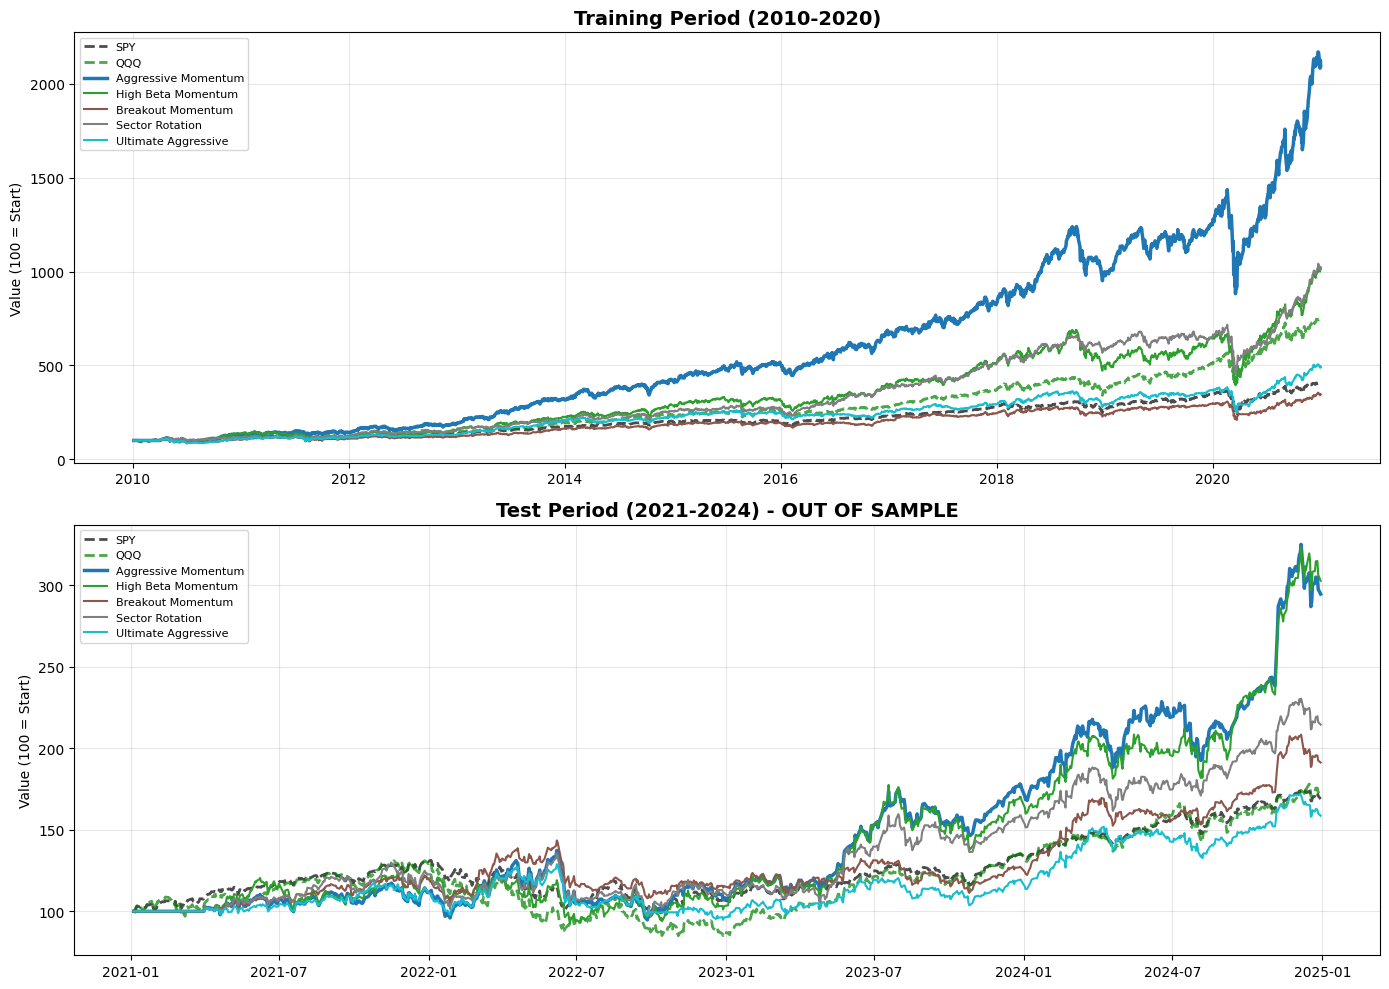

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Training
ax = axes[0]
train_spy_data = spy[(spy.index >= TRAIN_START) & (spy.index <= TRAIN_END)]
train_qqq_data = qqq[(qqq.index >= TRAIN_START) & (qqq.index <= TRAIN_END)]

spy_norm = train_spy_data / train_spy_data.iloc[0] * 100
qqq_norm = train_qqq_data / train_qqq_data.iloc[0] * 100

ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2, label='SPY', alpha=0.7)
ax.plot(qqq_norm.index, qqq_norm.values, 'g--', lw=2, label='QQQ', alpha=0.7)

colors = plt.cm.tab10(np.linspace(0, 1, len(train_results)))
for (name, result), color in zip(train_results.items(), colors):
    pv_norm = result.portfolio_values / result.portfolio_values.iloc[0] * 100
    lw = 2.5 if name == best else 1.5
    ax.plot(pv_norm.index, pv_norm.values, color=color, lw=lw, label=name)

ax.set_title('Training Period (2010-2020)', fontsize=14, fontweight='bold')
ax.set_ylabel('Value (100 = Start)')
ax.legend(loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

# Test
ax = axes[1]
test_spy_data = spy[(spy.index >= TEST_START) & (spy.index <= TEST_END)]
test_qqq_data = qqq[(qqq.index >= TEST_START) & (qqq.index <= TEST_END)]

spy_norm = test_spy_data / test_spy_data.iloc[0] * 100
qqq_norm = test_qqq_data / test_qqq_data.iloc[0] * 100

ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2, label='SPY', alpha=0.7)
ax.plot(qqq_norm.index, qqq_norm.values, 'g--', lw=2, label='QQQ', alpha=0.7)

for (name, result), color in zip(test_results.items(), colors):
    pv_norm = result.portfolio_values / result.portfolio_values.iloc[0] * 100
    lw = 2.5 if name == best else 1.5
    ax.plot(pv_norm.index, pv_norm.values, color=color, lw=lw, label=name)

ax.set_title('Test Period (2021-2024) - OUT OF SAMPLE', fontsize=14, fontweight='bold')
ax.set_ylabel('Value (100 = Start)')
ax.legend(loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

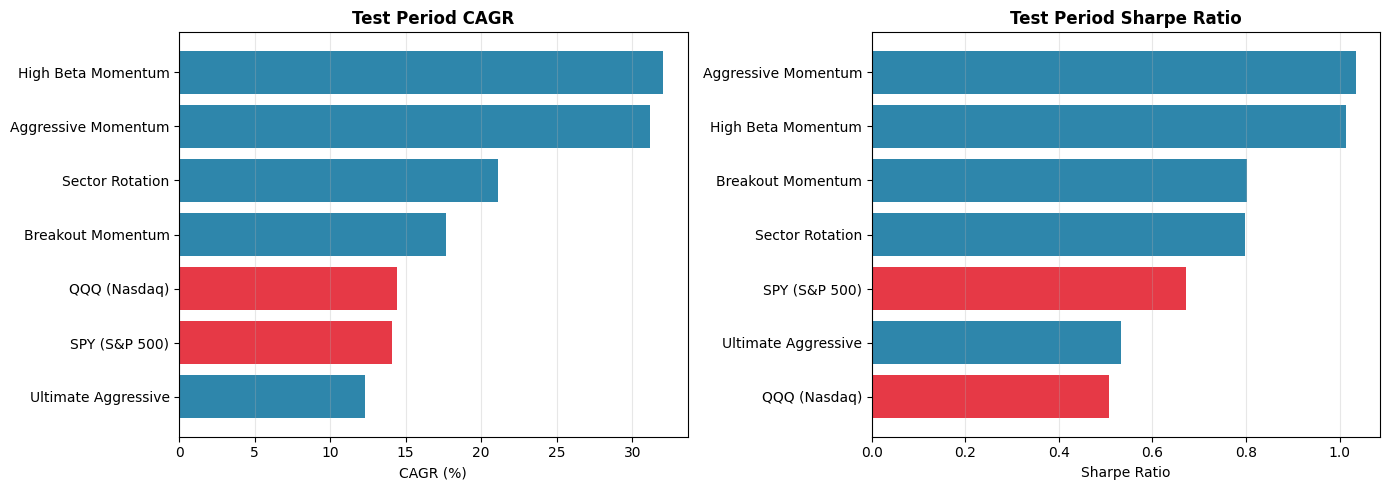

In [15]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CAGR comparison
ax = axes[0]
cagr_data = test_df[['Strategy', 'CAGR']].sort_values('CAGR', ascending=True)
colors = ['#E63946' if 'SPY' in s or 'QQQ' in s else '#2E86AB' for s in cagr_data['Strategy']]
ax.barh(cagr_data['Strategy'], cagr_data['CAGR'] * 100, color=colors)
ax.set_xlabel('CAGR (%)')
ax.set_title('Test Period CAGR', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Sharpe comparison
ax = axes[1]
sharpe_data = test_df[['Strategy', 'Sharpe']].sort_values('Sharpe', ascending=True)
colors = ['#E63946' if 'SPY' in s or 'QQQ' in s else '#2E86AB' for s in sharpe_data['Strategy']]
ax.barh(sharpe_data['Strategy'], sharpe_data['Sharpe'], color=colors)
ax.set_xlabel('Sharpe Ratio')
ax.set_title('Test Period Sharpe Ratio', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 7. Final Summary

In [16]:
print("="*70)
print("FINAL SUMMARY - V3 HIGH RETURNS")
print("="*70)

print(f"\nBest Strategy: {best}")

print("\n--- Training Period (2010-2020) ---")
train_s = train_results[best].summary()
print(f"CAGR: {train_s['CAGR']:.1%} vs SPY {spy_train['CAGR']:.1%} vs QQQ {qqq_train['CAGR']:.1%}")
print(f"Sharpe: {train_s['Sharpe']:.2f} vs SPY {spy_train['Sharpe']:.2f}")
print(f"Max DD: {train_s['Max Drawdown']:.1%} vs SPY {spy_train['Max Drawdown']:.1%}")

print("\n--- Test Period (2021-2024) ---")
test_s = test_results[best].summary()
print(f"CAGR: {test_s['CAGR']:.1%} vs SPY {spy_test['CAGR']:.1%} vs QQQ {qqq_test['CAGR']:.1%}")
print(f"Sharpe: {test_s['Sharpe']:.2f} vs SPY {spy_test['Sharpe']:.2f}")
print(f"Max DD: {test_s['Max Drawdown']:.1%} vs SPY {spy_test['Max Drawdown']:.1%}")

# Calculate outperformance
train_alpha = train_s['CAGR'] - spy_train['CAGR']
test_alpha = test_s['CAGR'] - spy_test['CAGR']

print(f"\n--- ALPHA (Outperformance vs SPY) ---")
print(f"Training Alpha: {train_alpha:.1%} per year")
print(f"Test Alpha: {test_alpha:.1%} per year")

print("\n" + "="*70)
print("V3 STRATEGY FEATURES:")
print("="*70)
print("""
1. CONCENTRATED PORTFOLIO: 15 stocks (vs 25-30 in V2)
2. GROWTH SECTOR TILT: 30% overweight to Tech/Comm/Consumer Disc
3. SHORTER MOMENTUM: 3-6 month lookback (vs 12 month)
4. MOMENTUM ACCELERATION: Favor stocks speeding up
5. BREAKOUT FOCUS: Stocks near 52-week highs
6. NO REGIME FILTER: Stay fully invested
7. NO STOPS: Let winners run
""")

FINAL SUMMARY - V3 HIGH RETURNS

Best Strategy: Aggressive Momentum

--- Training Period (2010-2020) ---
CAGR: 31.9% vs SPY 13.7% vs QQQ 20.2%
Sharpe: 1.19 vs SPY 0.62
Max DD: -38.6% vs SPY -33.7%

--- Test Period (2021-2024) ---
CAGR: 31.2% vs SPY 14.1% vs QQQ 14.4%
Sharpe: 1.03 vs SPY 0.67
Max DD: -31.0% vs SPY -24.5%

--- ALPHA (Outperformance vs SPY) ---
Training Alpha: 18.2% per year
Test Alpha: 17.1% per year

V3 STRATEGY FEATURES:

1. CONCENTRATED PORTFOLIO: 15 stocks (vs 25-30 in V2)
2. GROWTH SECTOR TILT: 30% overweight to Tech/Comm/Consumer Disc
3. SHORTER MOMENTUM: 3-6 month lookback (vs 12 month)
4. MOMENTUM ACCELERATION: Favor stocks speeding up
5. BREAKOUT FOCUS: Stocks near 52-week highs
6. NO REGIME FILTER: Stay fully invested
7. NO STOPS: Let winners run



In [17]:
# Show what stocks the best strategy would hold today
print("\n" + "="*70)
print(f"CURRENT HOLDINGS ({best})")
print("="*70)

# Get the strategy function
best_strategy_func = strategies[best]

# Generate current weights
current_weights = best_strategy_func(full_prices.index[-1], full_prices)

if current_weights:
    weights_df = pd.DataFrame([
        {'Ticker': t, 'Weight': w, 'Sector': sector_map.get(t, 'Unknown')}
        for t, w in current_weights.items()
    ]).sort_values('Weight', ascending=False)
    
    print(f"\nPortfolio as of {full_prices.index[-1].date()}:")
    print(weights_df.to_string(index=False))
    
    print("\nSector Allocation:")
    sector_alloc = weights_df.groupby('Sector')['Weight'].sum().sort_values(ascending=False)
    for sector, weight in sector_alloc.items():
        print(f"  {sector}: {weight:.1%}")
else:
    print("No positions generated for current date.")


CURRENT HOLDINGS (Aggressive Momentum)

Portfolio as of 2024-12-30:
Ticker   Weight                 Sector
   APP 0.066667 Information Technology
  PLTR 0.066667 Information Technology
  TSLA 0.066667 Consumer Discretionary
   UAL 0.066667            Industrials
  AXON 0.066667            Industrials
  HOOD 0.066667             Financials
   GEV 0.066667            Industrials
   TPR 0.066667 Consumer Discretionary
   CCL 0.066667 Consumer Discretionary
  AVGO 0.066667 Information Technology
  LULU 0.066667 Consumer Discretionary
  FTNT 0.066667 Information Technology
   RCL 0.066667 Consumer Discretionary
   APO 0.066667             Financials
  DECK 0.066667 Consumer Discretionary

Sector Allocation:
  Consumer Discretionary: 40.0%
  Information Technology: 26.7%
  Industrials: 20.0%
  Financials: 13.3%
